In [1]:
# Notebook to compute, partition, and invert quasigeostrophic potential vorticity
# For MEA 717, spring 2022, Gary Lackmann
# Kudos to Michael Gray for contributing a much faster method of computing Laplacians
#
# This code computes the QG PV vorticity, partitions it, and inverts specified pieces
#
# Some of the following imports are not used right now, but will retain for future flexibility
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pyproj

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
levels_850 = np.arange(1000, 2000, 50)

wnd_levels_850 = np.arange(20, 70, 5) 
levels_250 = np.arange(8200, 9600, 120)
wnd_levels_250 = np.arange(40, 170, 10) 
#levels = np.arange(8200, 9600, 120)
    
############## Create a colormap using ListedColormap #################

pmsl_levels = np.arange(960, 1060, 4)
# dark brown for state/coastlines
dark_brown = (0.4, 0.2, 0)
knots = 1.94384

In [3]:
datafiles = (glob.glob("/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d01_2017-01-09_00:00:00"))
datafiles.sort()
numfiles=len(datafiles)
ncfile = Dataset(datafiles[0])
p = getvar(ncfile, "pressure")
# Get the lat/lon coordinates
wrf_lats, wrf_lons = latlon_coords(p)

## WWRF longitude fix ######
new_lons =np.where(wrf_lons > 0, wrf_lons - 360, wrf_lons)

# Sigma for gaussian filter setting for SLP
sigma = 3


In [4]:
# Initialize an empty list to store the ivt arrays
rain_list = []
slp_list = []
ivt_list = []
# Get a list of all .npy files in the directory
file_paths = glob.glob('/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_*_20170108_00.npy')
slp_paths = glob.glob('/scratch/sawyer/wwrf/2017-01-09/ensemble_data/slp/slp_*_20170108_00.npy')
ivt_paths = glob.glob('/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_*_20170108_00.npy')

# Sort the file paths alphabetically
sorted_file_paths = sorted(file_paths)
sorted_slp_paths = sorted(slp_paths)
sorted_ivt_paths = sorted(ivt_paths)
# Loop through each file and load, filter, and append the data

for file in sorted_file_paths:
    print(file)
    rain_arrays = np.load(file, allow_pickle=True)
    
    rain_list.append(rain_arrays)
    print(rain_arrays.shape)

# Loop through each file and load, filter, and append the data

for file in sorted_slp_paths:
    print(file)
    slp_arrays = np.load(file, allow_pickle=True)
    slp_array = gaussian_filter(slp_arrays, sigma)
    slp_list.append(slp_array)

# Loop through each file and load, filter, and append the data
for file in sorted_ivt_paths:
    print(file)
    ivt_arrays = np.load(file, allow_pickle=True)
    ivt_array = gaussian_filter(ivt_arrays, 4)
    ivt_list.append(ivt_array)


/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_ishamel_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_ntu_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_p3_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_p3_2nd_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_p3_2xcloud_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_p3mom_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_thompson_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_thopmson_aa_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_wdm6_20170108_00.npy
(569, 618)
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/precip/total_precip_wsm6_20170108_00.npy
(569, 618)


In [5]:
print(len(rain_list))
# Make a list of title for plotting
titles = ['Ishmael','NTU','P3','P3 2nd', 'P3 2X', 'P3 3-mom',
          'Thompson', 'Thompson AA', 'WDM6', 'WSM6',]

10


In [6]:
lcc_projection = ccrs.LambertConformal(
    central_longitude=-120.0)
ivtlevs = np.arange(250,1250,250)
cmap_name = 'red_to_darkred'
colors = [(1, 0.0, 0.0), (0.5, 0, 0)]  # This defines "red" and "dark red"
n_bins = 3  # This is the number of bins in your colormap

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

/tmp/ipykernel_220464/3821104774.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


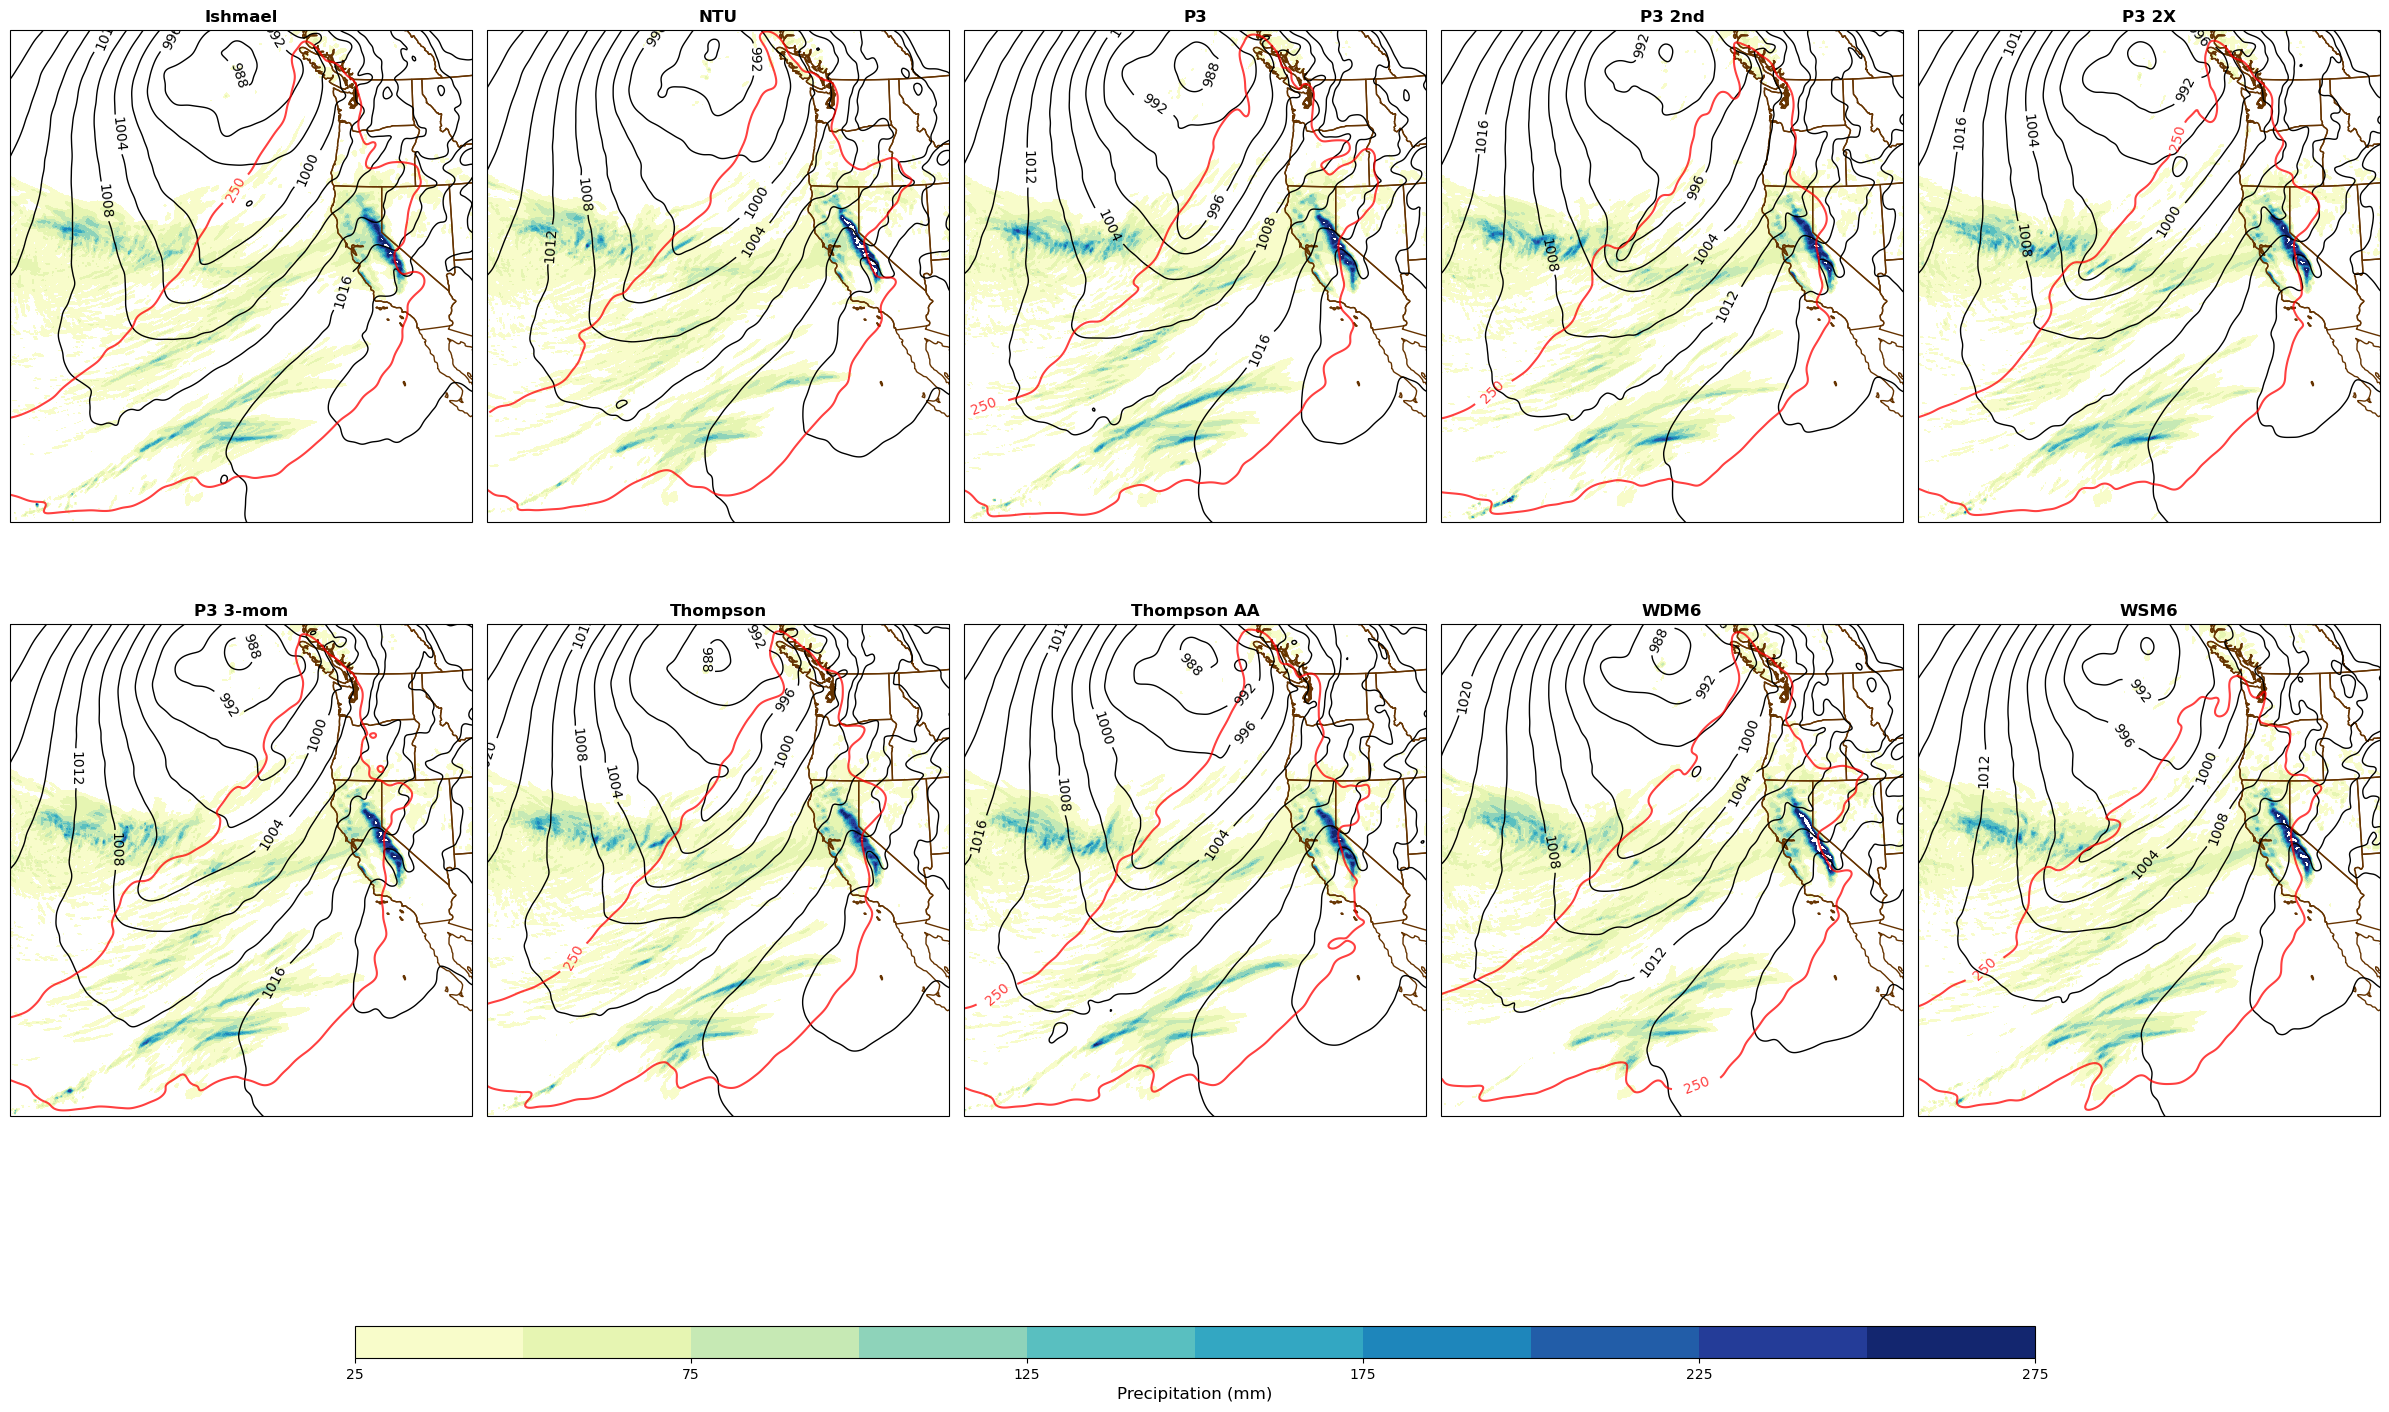

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(24, 16),
                        subplot_kw={'projection': lcc_projection})
axs = axs.ravel()  # Flatten axs

# Loop through the first N-1 elements
for i in range(len(rain_list)):
    ax = axs[i]
    ax.set_extent([-145, -114, 20, 50])
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor=dark_brown)
    ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor=dark_brown)
    ax.set_title(titles[i], fontweight='bold')
    cp = ax.contourf(to_np(new_lons), to_np(wrf_lats), to_np(rain_list[i]), cmap='YlGnBu', 
                     levels=np.arange(25, 300, 25), transform=ccrs.PlateCarree())
    cs = ax.contour(to_np(new_lons), to_np(wrf_lats), to_np(slp_list[i]),
                         colors = 'black',levels=pmsl_levels, linewidths=1.0, alpha=1,transform=crs.PlateCarree())
    plt.clabel(cs, fmt='%1.0f', inline=True,levels=pmsl_levels)
    
    cs = ax.contour(to_np(new_lons), to_np(wrf_lats), to_np(ivt_list[i]),
                         cmap=cm ,levels=[250], linewidths=1.5, alpha=0.75,transform=crs.PlateCarree())
    plt.clabel(cs, fmt='%1.0f', inline=True)

'''
# Handle the last plot separately
ax = axs[len(ivt_list) - 1]
ax.set_extent([-140, -113, 25, 50])
ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor='black')
ax.set_title(titles[-1], fontweight='bold')
cp = ax.contourf(to_np(wwrf_lons), to_np(lat), to_np(ivt_list[-1]), cmap='jet', 
                 levels=wnd_levels_850, transform=ccrs.PlateCarree())
cp2 = ax.contour(to_np(wwrf_lons), to_np(lat), to_np(slp_list[-1]),
                         colors = 'black',levels=levels_850, linewidths=.7, alpha=1,transform=crs.PlateCarree())
ax.clabel(cp2, fmt='%1.0f', inline=True,levels=levels_850)

# Turn off any remaining subplots
for i in range(len(ivt_list), len(axs)):
    axs[i].axis('off')

'''
plt.savefig('precip_slp_ivt_00z_8Jan')


# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Precipitation (mm)", fontsize = 12)

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the colorbar
plt.show()